### Title: 3MD3020 Deep Learning assignment notebook


#### Author : Khalil Bergaoui 
khalil.bergaoui@student.ecp.fr

This notebook is devided in three main sections:

  1. VAE on MNIST data

    1.1 MLP VAE
    
    1.2 U-net like VAE

  2. NLP Tutorial

  3. Transformer : with and without residual connections

### 1. Training VAE on MNIST dataset





In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
#Utility function used in the GAN TP

def show_tensor_images(image_tensor, num_images=64, size=(1, 28, 28)):
    """
    Given a tensor of images, number of images and size per image, this function plots and prints the images on a uniform grid
    """
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=8)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


In [ ]:
# Load MNIST dataset as tensors
batch_size = 64
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 1.1 MLP VAE

In this subsection, we will build a MLP VAE and train it on MNSIT data to answer questions 9 and 10 of the assignment.

Our implementation of the VAE is inspired from the following repo:
https://github.com/bvezilic/Variational-autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    """
    Encoder part of the VAE
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        p_x = F.relu(self.fc1(x))
        p_x = F.relu(self.fc2(p_x))

        return p_x


class Sampling(nn.Module):
    """
    Sampling Layer using the reparametrization trick as in question 8
    """
    def __init__(self, hidden_size, latent_size):
        super().__init__()
        self.mu = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, p_x):
        mu = self.mu(p_x)
        logvar = self.logvar(p_x)

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return std * eps + mu, logvar, mu


class Decoder(nn.Module):
    """
    Decoder part of the VAE
    """
    def __init__(self, latent_size, hidden_size, input_size):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size)

    def forward(self, z_x):
        q_x = F.relu(self.fc1(z_x))
        #For the last activation function we use sigmoid instead of relu 
        #because we constrain the generated pixel values to be between 0 and 1
        q_x = torch.sigmoid(self.fc2(q_x))

        return q_x


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = Encoder(input_size, hidden_size)
        self.latent_z = Sampling(hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, input_size)

    def forward(self, x):
        p_x = self.encoder(x)
        z, logvar, mu = self.latent_z(p_x)
        q_z = self.decoder(z)

        return q_z, logvar, mu, z

In [ ]:

def train_vae(epochs,model,dataloader,optimizer,display_steps,device):
        model.to(device)
        losses = []
        for epoch in range(1, epochs+1):
            print("-" * 20)
            print("Epoch {}".format(epoch))
            running_loss = 0

            # Visualization code
            if epoch in display_steps:
                model.eval()
                print('Plot real vs generated samples')
                mnist_batch = next(iter(dataloader))[0]
                cur_batch_size = mnist_batch.shape[0]
                real = mnist_batch.view(cur_batch_size, -1).to(device)
                fake = model(real)[0]
                show_tensor_images(fake)
                show_tensor_images(real)

                model.train()

            
            # Dataloader returns the batches
            for real, _ in tqdm(dataloader):
                optimizer.zero_grad()
                cur_batch_size = len(real)

                # Flatten the batch of real images from the dataset
                x = real.view(cur_batch_size, -1).to(device)
                #y = (x > 0.5).float().to(self.device)

                # Forward pass
                y_hat, logvar, mu, _ = model(x)

                # Compute loss
                loss = loss_criterion(y_hat, x, logvar, mu)

                # Compute gradients and update weights
                loss.backward()
                optimizer.step()

                running_loss += loss

            epoch_loss = running_loss / len(dataloader)
            print('Average loss {}'.format(epoch_loss))
            losses.append(epoch_loss.item())
        return losses


In [ ]:
n_epochs = 80
z_dim = 20
display_steps = [1,10,80]

lr = 1e-3
hidden_size = 512
in_size = next(iter(dataloader))[0].shape[2]**2
assert in_size==784

In [ ]:
model = VAE(in_size,hidden_size,z_dim)

In [ ]:
sum([p.numel() for p in model.parameters()])

1098040

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=lr)

def loss_criterion(inputs, targets, logvar, mu):
    # Reconstruction term
    reon_loss = F.binary_cross_entropy(inputs, targets, reduction="sum")
    # Regularization term
    reg_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reon_loss + reg_loss

--------------------
Epoch 1
Plot real vs generated samples


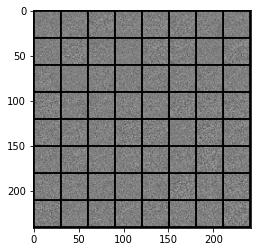

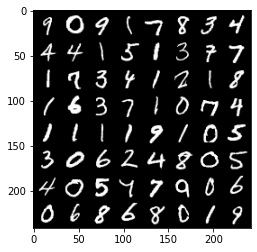


Average loss 9421.6533203125
--------------------
Epoch 2



Average loss 7430.302734375
--------------------
Epoch 3



Average loss 7123.82763671875
--------------------
Epoch 4



Average loss 6991.005859375
--------------------
Epoch 5



Average loss 6915.45947265625
--------------------
Epoch 6



Average loss 6857.79736328125
--------------------
Epoch 7



Average loss 6814.70703125
--------------------
Epoch 8



Average loss 6777.32177734375
--------------------
Epoch 9



Average loss 6751.0048828125
--------------------
Epoch 10
Plot real vs generated samples


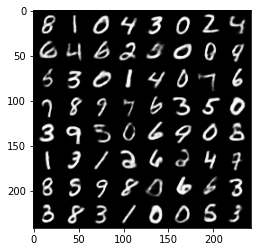

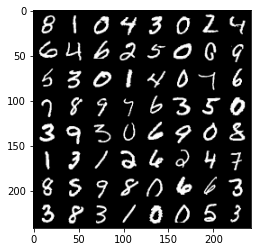


Average loss 6722.916015625
--------------------
Epoch 11



Average loss 6703.72265625
--------------------
Epoch 12



Average loss 6684.4462890625
--------------------
Epoch 13



Average loss 6666.50048828125
--------------------
Epoch 14



Average loss 6655.103515625
--------------------
Epoch 15



Average loss 6641.0859375
--------------------
Epoch 16



Average loss 6628.10498046875
--------------------
Epoch 17



Average loss 6615.02587890625
--------------------
Epoch 18



Average loss 6602.06591796875
--------------------
Epoch 19



Average loss 6596.154296875
--------------------
Epoch 20



Average loss 6584.46728515625
--------------------
Epoch 21



Average loss 6573.93408203125
--------------------
Epoch 22



Average loss 6566.466796875
--------------------
Epoch 23



Average loss 6559.7734375
--------------------
Epoch 24



Average loss 6547.78515625
--------------------
Epoch 25



Average loss 6546.4990234375
--------------------
Epoch 26



Average loss 6535.3349609375
--------------------
Epoch 27



Average loss 6532.2314453125
--------------------
Epoch 28



Average loss 6525.01025390625
--------------------
Epoch 29



Average loss 6516.4912109375
--------------------
Epoch 30



Average loss 6511.46923828125
--------------------
Epoch 31



Average loss 6507.1796875
--------------------
Epoch 32



Average loss 6500.900390625
--------------------
Epoch 33



Average loss 6494.041015625
--------------------
Epoch 34



Average loss 6488.62646484375
--------------------
Epoch 35



Average loss 6485.92041015625
--------------------
Epoch 36



Average loss 6482.83984375
--------------------
Epoch 37



Average loss 6476.68798828125
--------------------
Epoch 38



Average loss 6471.75341796875
--------------------
Epoch 39



Average loss 6468.63232421875
--------------------
Epoch 40



Average loss 6461.845703125
--------------------
Epoch 41



Average loss 6460.2841796875
--------------------
Epoch 42



Average loss 6456.58544921875
--------------------
Epoch 43



Average loss 6453.3330078125
--------------------
Epoch 44



Average loss 6450.02197265625
--------------------
Epoch 45



Average loss 6447.06201171875
--------------------
Epoch 46



Average loss 6443.166015625
--------------------
Epoch 47



Average loss 6439.54931640625
--------------------
Epoch 48



Average loss 6436.12841796875
--------------------
Epoch 49



Average loss 6432.8759765625
--------------------
Epoch 50



Average loss 6429.279296875
--------------------
Epoch 51



Average loss 6430.24755859375
--------------------
Epoch 52



Average loss 6426.40673828125
--------------------
Epoch 53



Average loss 6423.291015625
--------------------
Epoch 54



Average loss 6416.80029296875
--------------------
Epoch 55



Average loss 6416.42041015625
--------------------
Epoch 56



Average loss 6414.25732421875
--------------------
Epoch 57



Average loss 6412.59130859375
--------------------
Epoch 58



Average loss 6409.67138671875
--------------------
Epoch 59



Average loss 6406.95947265625
--------------------
Epoch 60



Average loss 6404.4853515625
--------------------
Epoch 61



Average loss 6404.1083984375
--------------------
Epoch 62



Average loss 6401.7412109375
--------------------
Epoch 63



Average loss 6396.86083984375
--------------------
Epoch 64



Average loss 6398.33740234375
--------------------
Epoch 65



Average loss 6394.24365234375
--------------------
Epoch 66



Average loss 6389.29052734375
--------------------
Epoch 67



Average loss 6391.25537109375
--------------------
Epoch 68



Average loss 6388.3388671875
--------------------
Epoch 69



Average loss 6388.1650390625
--------------------
Epoch 70



Average loss 6383.54541015625
--------------------
Epoch 71



Average loss 6382.447265625
--------------------
Epoch 72



Average loss 6381.10302734375
--------------------
Epoch 73



Average loss 6380.109375
--------------------
Epoch 74



Average loss 6377.2607421875
--------------------
Epoch 75



Average loss 6376.66162109375
--------------------
Epoch 76



Average loss 6375.533203125
--------------------
Epoch 77



Average loss 6372.45849609375
--------------------
Epoch 78



Average loss 6374.43310546875
--------------------
Epoch 79



Average loss 6368.90380859375
--------------------
Epoch 80
Plot real vs generated samples


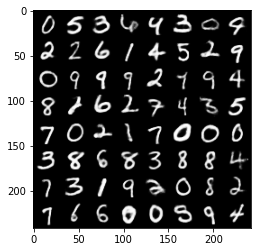

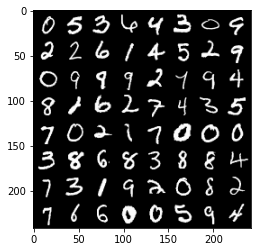


Average loss 6367.271484375


In [ ]:
L = train_vae(80,model,dataloader,optimizer,display_steps,device)

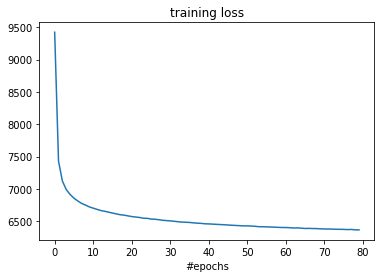

In [ ]:
plt.plot(L)
plt.xlabel('#epochs')
tt = plt.title('training loss')


#### 1.2 U-net like, convolutional VAE

In this subsection, we will implement a VAE by replacing the MLP encoder and decoder with convolutional upsampling and downsampling networks inspired from the U-net architecture.

The structure of the below code chunk can be found here: https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In order to convert it into a VAE, we added the implementation of the latent space sampling operation after the third convolution.

In [ ]:
from torch import nn
class UNET_VAE(nn.Module):
    def __init__(self, in_channels, out_channels,hidden_size,latent_size):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 8, 5, 3)
        self.conv2 = self.contract_block(8, 16, 3, 1)
        self.conv3 = self.contract_block(16, 32, 3, 1)

        #Sampling layer 
        self.latent_z = Sampling(hidden_size,latent_size)
        self.decode1 = nn.Linear(latent_size,hidden_size)

        self.upconv3 = self.expand_block(32, 16, 3, 1)
        self.upconv2 = self.expand_block(16*2, 8, 3, 1)
        self.upconv1 = self.expand_block(8*2, out_channels, 4, 1)

    def __call__(self, x,batch_size):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        #latent space sampling
        p_x = conv3.view(batch_size, -1) #flatten
        z, logvar, mu = self.latent_z(p_x)
        #Reconstructing conv3 from sample
        rec_conv3 = self.decode1(z).view(batch_size,32,4,4)#unflatten

        #upsampling part
        upconv3 = self.upconv3(rec_conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1,logvar,mu,z

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                            torch.nn.Sigmoid(), 
                            )
        return expand

In [ ]:
def train_conv_vae(epochs,model,dataloader,optimizer,display_steps,device):
        model.to(device)
        losses = []
        for epoch in range(1, epochs+1):
            print("-" * 20)
            print("Epoch {}".format(epoch))
            running_loss = 0

            # Visualization code
            if epoch in display_steps:
                model.eval()
                print('Plot real vs generated samples')
                mnist_batch = next(iter(dataloader))[0]
                cur_batch_size = mnist_batch.shape[0]
                real = mnist_batch.to(device)
                fake = model(real,cur_batch_size)[0]
                show_tensor_images(fake.view(cur_batch_size, -1))
                show_tensor_images(real.view(cur_batch_size, -1))

                model.train()

            
            # Dataloader returns the batches
            for real, _ in tqdm(dataloader):
                optimizer.zero_grad()
                cur_batch_size = real.shape[0]

                # Flatten the batch of real images from the dataset
                #x = real.view(cur_batch_size, -1).to(device)
                #y = (x > 0.5).float().to(self.device)
                x = real.to(device)
                # Forward pass
                y_hat, logvar, mu, _ = model(x,cur_batch_size)

                # Compute loss
                loss = loss_criterion(y_hat, x, logvar, mu)

                # Compute gradients and update weights
                loss.backward()
                optimizer.step()

                running_loss += loss

            epoch_loss = running_loss / len(dataloader)
            print('Average loss {}'.format(epoch_loss))
            losses.append(epoch_loss.item())
        return losses

In [ ]:
n_epochs = 80
z_dim = 20
display_steps = [1,10,80]
#batch_size = 64
lr = 1e-3
hidden_size = 512

In [ ]:
conv_model = UNET_VAE(1,1,hidden_size,z_dim)
sum([p.numel() for p in conv_model.parameters()])

63816

In [ ]:
from torch import optim
optimizer_conv = optim.Adam(conv_model.parameters(), lr=lr)
def loss_criterion(inputs, targets, logvar, mu):
    # Reconstruction term
    reon_loss = F.binary_cross_entropy(inputs, targets, reduction="sum")
    # Regularization term
    reg_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reon_loss + reg_loss

--------------------
Epoch 1
Plot real vs generated samples


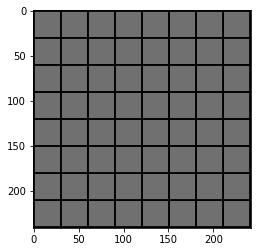

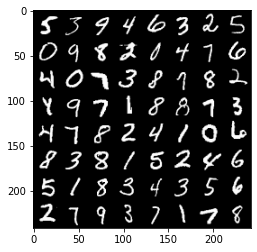


Average loss 22152.404296875
--------------------
Epoch 2



Average loss 13381.8935546875
--------------------
Epoch 3



Average loss 9429.2841796875
--------------------
Epoch 4



Average loss 7323.54931640625
--------------------
Epoch 5



Average loss 6076.5390625
--------------------
Epoch 6



Average loss 5293.65771484375
--------------------
Epoch 7



Average loss 4774.16015625
--------------------
Epoch 8



Average loss 4420.94580078125
--------------------
Epoch 9



Average loss 4174.22216796875
--------------------
Epoch 10
Plot real vs generated samples


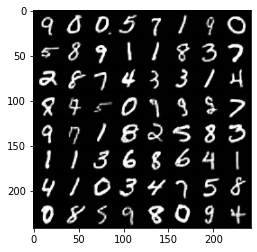

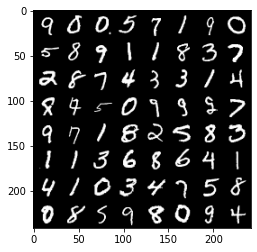


Average loss 4000.320556640625
--------------------
Epoch 11



Average loss 3877.492431640625
--------------------
Epoch 12



Average loss 3786.8681640625
--------------------
Epoch 13



Average loss 3725.100830078125
--------------------
Epoch 14



Average loss 3679.467041015625
--------------------
Epoch 15



Average loss 3648.879638671875
--------------------
Epoch 16



Average loss 3621.798828125
--------------------
Epoch 17



Average loss 3602.990234375
--------------------
Epoch 18



Average loss 3583.90771484375
--------------------
Epoch 19



Average loss 3564.894287109375
--------------------
Epoch 20



Average loss 3550.251220703125
--------------------
Epoch 21



Average loss 3540.79638671875
--------------------
Epoch 22



Average loss 3529.3369140625
--------------------
Epoch 23



Average loss 3522.27294921875
--------------------
Epoch 24



Average loss 3516.743408203125
--------------------
Epoch 25



Average loss 3511.63037109375
--------------------
Epoch 26



Average loss 3507.03857421875
--------------------
Epoch 27



Average loss 3502.7783203125
--------------------
Epoch 28



Average loss 3499.43505859375
--------------------
Epoch 29



Average loss 3496.6171875
--------------------
Epoch 30



Average loss 3493.312744140625
--------------------
Epoch 31



Average loss 3492.746826171875
--------------------
Epoch 32



Average loss 3491.165283203125
--------------------
Epoch 33



Average loss 3487.69091796875
--------------------
Epoch 34



Average loss 3485.945068359375
--------------------
Epoch 35



Average loss 3484.54296875
--------------------
Epoch 36



Average loss 3482.787841796875
--------------------
Epoch 37



Average loss 3482.580322265625
--------------------
Epoch 38



Average loss 3479.735595703125
--------------------
Epoch 39



Average loss 3479.645263671875
--------------------
Epoch 40



Average loss 3477.830810546875
--------------------
Epoch 41



Average loss 3476.813232421875
--------------------
Epoch 42



Average loss 3476.958740234375
--------------------
Epoch 43



Average loss 3474.537109375
--------------------
Epoch 44



Average loss 3474.1494140625
--------------------
Epoch 45



Average loss 3473.36376953125
--------------------
Epoch 46



Average loss 3472.208984375
--------------------
Epoch 47



Average loss 3471.379150390625
--------------------
Epoch 48



Average loss 3470.62744140625
--------------------
Epoch 49



Average loss 3469.87939453125
--------------------
Epoch 50



Average loss 3470.094970703125
--------------------
Epoch 51



Average loss 3468.85400390625
--------------------
Epoch 52



Average loss 3468.709228515625
--------------------
Epoch 53



Average loss 3467.46435546875
--------------------
Epoch 54



Average loss 3467.36083984375
--------------------
Epoch 55



Average loss 3466.49072265625
--------------------
Epoch 56



Average loss 3465.82373046875
--------------------
Epoch 57



Average loss 3465.0966796875
--------------------
Epoch 58



Average loss 3465.7236328125
--------------------
Epoch 59



Average loss 3463.60205078125
--------------------
Epoch 60



Average loss 3464.40576171875
--------------------
Epoch 61



Average loss 3463.208984375
--------------------
Epoch 62



Average loss 3463.26025390625
--------------------
Epoch 63



Average loss 3462.51904296875
--------------------
Epoch 64



Average loss 3462.840087890625
--------------------
Epoch 65



Average loss 3462.224853515625
--------------------
Epoch 66



Average loss 3461.263671875
--------------------
Epoch 67



Average loss 3461.46484375
--------------------
Epoch 68



Average loss 3460.295654296875
--------------------
Epoch 69



Average loss 3460.4892578125
--------------------
Epoch 70



Average loss 3460.298095703125
--------------------
Epoch 71



Average loss 3460.037109375
--------------------
Epoch 72



Average loss 3459.802001953125
--------------------
Epoch 73



Average loss 3458.614990234375
--------------------
Epoch 74



Average loss 3459.053955078125
--------------------
Epoch 75



Average loss 3458.7734375
--------------------
Epoch 76



Average loss 3458.823486328125
--------------------
Epoch 77



Average loss 3458.191650390625
--------------------
Epoch 78



Average loss 3458.202880859375
--------------------
Epoch 79



Average loss 3457.583251953125
--------------------
Epoch 80
Plot real vs generated samples


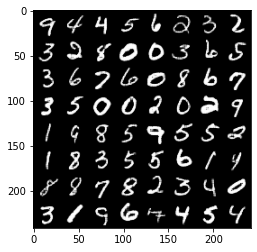

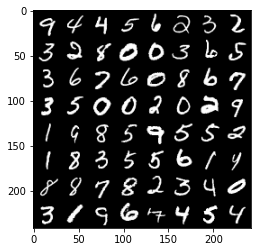


Average loss 3457.249267578125


In [ ]:
L_conv = train_conv_vae(n_epochs,conv_model,dataloader,optimizer_conv,display_steps,device)

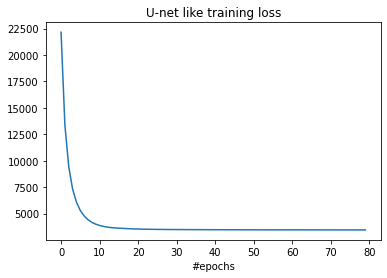

In [ ]:
plt.plot(L_conv,label='U-net like VAE')
plt.xlabel('#epochs')
tt = plt.title('training loss')

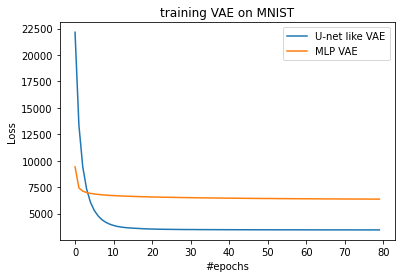

In [ ]:
#Compare loss curves
plt.plot(L_conv,label='U-net like VAE')
plt.plot(L,label='MLP VAE')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend()
tt = plt.title('training VAE on MNIST')


### 2.NLP Tutorial

In this section, we will go through the tutorialhttps://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html in order to explore the impact of teacher forcing.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

#Read datafile
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #Specify directory here
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


#Set maximum sentence length
MAX_LENGTH = 10
#Filter simple entences
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


#Data preparation pipeline
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [ ]:
#Display random sample of pair sentences
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['nous sommes de vieux amis .', 'we re old friends .']


### Seq2Seq Model

In [ ]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#Decoder with attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training

Helper functions

In [ ]:

#Transform sentences to tensors of word indices in each langage
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


# Other helper functions
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Training model

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
hidden_size = 256
teacher_losses = []
#Train for multiple teacher_forcing_ration settings
teacher_forcing = [0,0.2,0.5,0.8,1]
for i in range(len(teacher_forcing)):

  encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
  attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
  teacher_forcing_ratio = teacher_forcing[i]
  print('Training with teacher forcing ratio = {}'.format(teacher_forcing_ratio))
  loss = trainIters(encoder1, attn_decoder1, 30000, print_every=5000)
  teacher_losses.append(loss)
  del encoder1
  del attn_decoder1
  




Training with teacher forcing ratio = 0
1m 35s (- 7m 55s) (5000 16%) 2.9506
3m 10s (- 6m 21s) (10000 33%) 2.3740
4m 46s (- 4m 46s) (15000 50%) 2.0640
6m 24s (- 3m 12s) (20000 66%) 1.8305
8m 1s (- 1m 36s) (25000 83%) 1.6307
9m 39s (- 0m 0s) (30000 100%) 1.4791
Training with teacher forcing ratio = 0.2
1m 34s (- 7m 51s) (5000 16%) 2.9357
3m 9s (- 6m 19s) (10000 33%) 2.3697
4m 47s (- 4m 47s) (15000 50%) 2.0393
6m 23s (- 3m 11s) (20000 66%) 1.7889
7m 59s (- 1m 35s) (25000 83%) 1.5831
9m 35s (- 0m 0s) (30000 100%) 1.3926
Training with teacher forcing ratio = 0.5
1m 38s (- 8m 10s) (5000 16%) 2.8538
3m 10s (- 6m 21s) (10000 33%) 2.2799
4m 44s (- 4m 44s) (15000 50%) 1.9959
6m 20s (- 3m 10s) (20000 66%) 1.7255
7m 58s (- 1m 35s) (25000 83%) 1.5483
9m 35s (- 0m 0s) (30000 100%) 1.3905
Training with teacher forcing ratio = 0.8
1m 38s (- 8m 11s) (5000 16%) 2.7192
3m 15s (- 6m 31s) (10000 33%) 2.1164
4m 52s (- 4m 52s) (15000 50%) 1.8054
6m 29s (- 3m 14s) (20000 66%) 1.5891
8m 5s (- 1m 37s) (25000 83

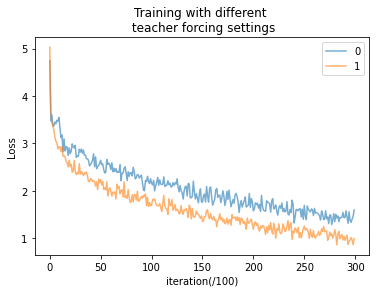

In [ ]:
for i in range(len(teacher_losses)):
  if i in [0,4]:
    plt.plot(teacher_losses[i],label='{}'.format(teacher_forcing[i]),alpha=0.6)

#plt.hlines(y=[1.4],xmin=150,xmax=300,ls='--')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('iteration(/100)')
tt=plt.title('Training with different \n teacher forcing settings')

As seen in the figure above, using teacher forcing allows to achieve smaller values of the loss function in fewer training epochs.

### 3.Transformer

Question 17:

In this section, we will use the same data used in the previous section in order to design a toy experiment to answer question 17.
We will use pytorch's Transformer model (torch.nn.Transformer) and we will implement our custom encoder to adapt to question 16. In particular we will consider only self-attention and normalization layers in the encoder and make experiments using the encoder with and without the residual connections.

Some of the code chunks below can be found here : https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

We added some changes in order to adapt to our interest.

In [ ]:
class CustomEncoderLayer(nn.Module):
    """
    Custom encoder layer to be used in building the custom encoder for torch.nn.Transformer

    The boolean variabl "residual" allows for implementation of both equations 21 and 22 of the assignment
    """

    def __init__(self, d_model, heads, residual,dropout = 0.1):
        super().__init__()
        self.residual = residual
        self.norm = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, heads)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, mask,src_key_padding_mask):
        if self.residual:
          #Equation 22
          x2 = self.norm(x)
          A, w =self.attn(x2,x2,x2,src_key_padding_mask)

          x = x + self.dropout(A)

        else:
          #Equation 21
          A,w = self.attn(x,x,x,src_key_padding_mask)
          x = self.norm(x+self.dropout(A))
        
        return x

class CustomEncoder(nn.Module):
    def __init__(self, d_model, N, heads,resiudal):
        super().__init__()
        self.N = N
        #self.embed = nn.Embedding(vocab_size, d_model)
        #self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(CustomEncoderLayer(d_model, heads,residual), N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, src, mask,src_key_padding_mask):
        x = src
        #x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask,src_key_padding_mask)
        return self.norm(x)

def get_clones(module, N):
    import copy
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

Please make sure to execute the first part of the assignment i.e the NLP tutorial , because we will use the previously built source vocabulary.

In [ ]:
#Transformer model parameters
d_model = 512 #default embedding size
heads = 1 #multihead attention parameter
N = 30 #Number of encoding layers (and decoding layers) in the encoder (and decoder) of the Transformer
residual = False # Set to false if we want to use Equation 21 and to True if we want to use equation 22

#Predefine embedding
#In our toy experiment we use a randomly initialized embedding layer
#src_vocab = input_lang.n_words #input_lang has already been defined in the previous section
"""
#Display random sample of pair sentences
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))
"""
embd = nn.Embedding(src_vocab,d_model).to(device)

In [ ]:
#Delete existing models on cuda device
try:
  del enc
  del transformer_model
except:
  print('no models on device')

no models on device


In [ ]:

def get_custom_transformer(d_model,heads,N,residual,device):
  #Custom encoder for the transformer model
  enc = CustomEncoder(d_model,N,heads,residual)

  #Initialize the encoder's parameters using Xavier uniform initialization
  for p in enc.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  #Custom Transformer model
  transformer_model = nn.Transformer(nhead=1,num_decoder_layers =N,custom_encoder=enc).to(device)
  return transformer_model

In [ ]:
transformer_model = get_custom_transformer(d_model,heads,N,residual,device)
#Optimizers and loss function
encoder_optimizer = optim.SGD(transformer_model.encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(transformer_model.decoder.parameters(), lr=0.01)

#In our toy example, we use MSE loss because we compute the loss
#over embeddings instead of final sentences
#This is because we are only intrested in observing the 
#gradient behaviour and not the optimization of the model in performing the tranlation task
criterion = nn.MSELoss()


In [ ]:
n_epochs = 100
#Training pair(french sentence, english target translation)
training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_epochs)]

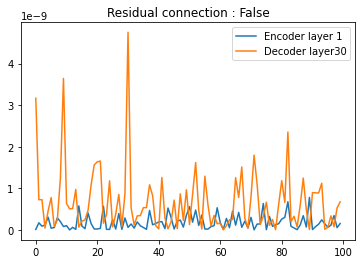

In [ ]:
#Train model on toy experiment
def train_for_grads(transformer_model,training_pairs,n_epochs,encoder_optimizer,decoder_optimizer,criterion):
  #Initialize lists
  first_grads_min = []
  last_grads_min =[]
  #Train for a few epochs and plot the backpropagated gradients
  for epoch in range(n_epochs):
    #print(epoch)
    #get training pair
    training_pair = training_pairs[epoch]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    #Embedding
    src = embd(input_tensor)
    trg = embd(target_tensor)

    #Set gradients to zero
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #Forward pass
    out = transformer_model(src,trg)
    #Compute indicative loss
    loss= criterion(out,trg)
    #Backpropagate error
    loss.backward()
    #Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    #Get gradients wrt to first self attention layer of the encoder
    first_grad_min= transformer_model.encoder.layers[0].attn.out_proj.weight.grad.abs().min().item()
    #Get gradients wrt to last self attention layer of the decoder
    last_grad_min = transformer_model.decoder.layers[N-1].self_attn.out_proj.weight.grad.abs().min().item()
    #Save to lists
    first_grads_min.append(first_grad_min)
    last_grads_min.append(last_grad_min)


    loss=0
  return first_grads_min,first_grads_min

first_grads_min,first_grads_min = train_for_grads(transformer_model,training_pairs,n_epochs,encoder_optimizer,decoder_optimizer,criterion)
plt.plot(first_grads_min,label='Encoder layer 1')
plt.plot(last_grads_min,label='Decoder layer{}'.format(N))
plt.legend()
tt=plt.title('Residual connection : {}'.format(residual))

